1. ~~To create a Jupyter .ipynb notebook for data analysis~~
2. ~~Import your data or data files and to save as dataframes~~
3. ~~Examine your data, columns and rows and rename and adjust indexing and encoding as appropriate~~
4. ~~Clean null and blank values, and consider to drop rows, as well as to manipulate data and adjust data types as appropriate, including dates and time, or setting appropriate indices. Adjusting specific values and replacing strings and characters for the data wrangling process.~~
5. ~~Explore analysis with graphing and visualizations with matplotlib and seaborn and alternative visualization packages (Plotly, bokeh, altair, vincent)~~
6. ~~Perform additional analysis by creating new columns for calculations, including aggregator functions, counts and groupbys.~~
7. Encode categorical variables with a variety of techniques through logical conditions, where clauses, or one hot encoding
8. Re-run calculations, including crosstabs or pivots, and new graphs to see results
9. Create correlation matrices, pairplots and heatmaps to determine which attributes should be features for your models and which attributes should not
10. Identify the response variables(s) that you would want to predict/classify/interpret with data science
11. ~~Perform additional feature engineering as necessary, including Min/Max, Normalizaton, Scaling, and additional Pipeline changes that may be beneficial or helpful when you run machine learning~~
12. ~~Merge or concatenate datasets if you have not already, based on common keys or unique items for more in-depth analysis~~
13. ~~Add commenting and markdown throughout the jupyter notebook to explain the interpretation of your results or to comment on code that may not be human readable, and help you recall for you what you are referencing.~~ 
14. ~~To create a markdown .md milestone report that shows and explains the results of what you have accomplished to date in this part of your course project. Consider also creating a .pdf or .pptx to display initial results, aha moments, or findings that would be novel or fascinating for your final presentations.~~


# Part 3: Exploratory Data Analysis
Project: New Coffee Shop Location
<br/>

#### Contents:
- <a href="#import_and_structure"><font color="green">Import and structure data sets</font></a>
    - <a href="#import_zip"><font color="green">Import zip_codes file</font></a>
    - <a href="#import_acs"><font color="green">Import and combine ACS population datasets</font></a>
    - <a href="#yelp_api"><font color="red">Yelp API Calls & reformatting (don't run these, import in next section)</font></a>
    - <a href="#import_foursquare"><font color="red">Import and reformat Foursquare dataset (don't run these, import in next section)</font></a>
- <a href="#reimport_data"><font color="green">Import cleaned datasets</font></a>
- <a href="#explore_data"><font color="green">Explore data</font></a>
- <a href="#explore_data_old"><font color="red">Explore data (Old Hypotheses)</font></a>
    
    

<a id="import_and_structure"></a>
# Import data files and save as dataframes.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

<a id="import_zip"></a>
### Import zip_codes file (which contains all zip codes in dc-metro) into a python list.

In [2]:
import csv
with open('./data/zip_codes.csv', 'r') as f:
    reader = csv.reader(f)
    zip_codes = list(reader)
    
# convert list of lists attained from csv.reader to single flat list
zip_codes_flat = [item for sublist in zip_codes for item in sublist]

<a id="import_acs"></a>
### Import ACS Population Dataset

In [3]:
# create dataframe with 2015 & 2016 data to compare for change in population
popul2015_df = pd.read_csv('./data/ACS_15_5YR_B01003_with_ann.csv', names=('zip_code', 'estimate_total'), skiprows=1)
popul2016_df = pd.read_csv('./data/ACS_16_5YR_B01003_with_ann.csv', names=('zip_code', 'estimate_total'), skiprows=1)
populchange_df = popul2015_df.merge(popul2016_df, on="zip_code", suffixes=('_2015', '_2016'))

populchange_df.head()

,zip_code,estimate_total_2015,estimate_total_2016
0,20001,43731,44998
1,20002,57412,59659
2,20003,28538,29071
3,20004,1667,1708
4,20005,12947,13063


In [4]:
populchange_df = populchange_df[populchange_df.zip_code.isin(zip_codes_flat)]

In [5]:
populchange_df.dtypes

zip_code               int64
estimate_total_2015    int64
estimate_total_2016    int64
dtype: object

In [6]:
populchange_df['zip_code'] = populchange_df['zip_code'].astype(str)

<a id="yelp_api"></a>
### Import Yelp dataset/call Yelp API.
    - After importing the dataset I found it to be missing all data from DC area (maybe corrupted file?), so I chose to use  Yelp API.
#### Note: <font color=Red>Don't run this code. Outputted, cleaned dataframe saved to file below and re-imported in the next section. I've marked where to begin running in red below.</font>

In [7]:
# businesses = pd.read_json('./data/business.json', lines=True)
# businesses.shape
# businesses.dtypes
# businesses.head()
# businesses[businesses.city.isin(zip_codes_flat)]

In [8]:
# This takes a very long time to run (calls the API 1200ish times; 10 minutes on my PC)
# Query the yelp api for each zip code in the DC metro area
# Since Yelp limit is 50 for businesses returned, we need to loop through pages of 50 using offsets

import requests

url = "https://api.yelp.com/v3/businesses/search"

dict_responses = {}
# for each zip code, gather up to 1001 businesses (should be enough for all businesses in each zip)
for i in zip_codes_flat:
    j = 1
    while j <= 1001:
        querystring = {'location': i, 'limit':50, 'offset':j}

        headers = {
            'authorization': #insert api key,
            'cache-control': "no-cache",
            }

        response = requests.request("GET", url, headers=headers, params=querystring)

        response_todict = response.json()
        try:
            response_todict[str(int(i)+int(j))] = response_todict.pop('businesses')
        except:
            j = 1002
        else:    
            dict_responses.update(response_todict)
            j = j + 50

In [9]:
# Clean up the response from the api

list_of_businesses = []

for key, item in dict_responses.items():
    list_of_businesses.append(item)

del(list_of_businesses[0:2])

# more cleanup; list is currently list of lists of dictionaries due to how api was called
# convert to just list of dictionaries

list_of_businesses_formatting = []

for i in list_of_businesses:
    for j in i:
        list_of_businesses_formatting.append(j)

#### I need to normalize the json data so that each data point is in its own column.

In [10]:
# Change formatting of categories column to only include "title", not "alias" (makes normalization easier)
for idx, val in enumerate(list_of_businesses_formatting):
    list_categories = []
    for idx2, val2 in enumerate(val['categories']):
        list_categories.append(list_of_businesses_formatting[idx]['categories'][idx2]['title'])
    val['categories'] = list_categories

In [11]:
# This isn't technically normalized all the way since categories still has multiple values.
# Good enough for analysis I need
from pandas.io.json import json_normalize
businesses_df = json_normalize(list_of_businesses_formatting)

In [12]:
businesses_df.head(2)

,alias,categories,coordinates.latitude,coordinates.longitude,display_phone,distance,id,image_url,is_closed,location.address1,...,location.display_address,location.state,location.zip_code,name,phone,price,rating,review_count,transactions,url
0,old-ebbitt-grill-washington,"[Bars, American (Traditional), Breakfast & Bru...",38.898005,-77.033362,(202) 347-4800,1428.775801,iyBbcXtQSBfiwFQZwVBNaQ,https://s3-media2.fl.yelpcdn.com/bphoto/KBCezp...,False,675 15th St NW,...,"[675 15th St NW, Washington, DC 20005]",DC,20005,Old Ebbitt Grill,+12023474800,$$,4.0,6544,[],https://www.yelp.com/biz/old-ebbitt-grill-wash...
1,a-baked-joint-washington-9,"[Coffee & Tea, Breakfast & Brunch, Sandwiches]",38.902411,-77.017139,(202) 408-6985,547.273915,SpCeYPhky4gsWa9-IBtw2A,https://s3-media1.fl.yelpcdn.com/bphoto/iTBw1K...,False,440 K St NW,...,"[440 K St NW, Washington, DC 20001]",DC,20001,A Baked Joint,+12024086985,$,4.5,1218,[],https://www.yelp.com/biz/a-baked-joint-washing...


#### My looping api call technique resulted in many duplicates, as we examine and fix below (id is unique).

In [13]:
businesses_df.id.value_counts().head()

SvjE3q-uYpyjqYKh714IPw    16
ynuv5y74SB2gEXFPjMYb_Q    16
F6jgtkBLdyjHYhDO79Z1lA    16
hrWvnULW3ragGALYVEAybA    16
S0WNMOKJ5c3NXuC_-7lE2Q    14
Name: id, dtype: int64

In [14]:
businesses_df.drop_duplicates(subset='id', inplace=True)

In [15]:
businesses_df.shape

(4222, 24)

#### Now I will drop columns that I won't need during this project.

In [16]:
businesses_df.drop(['alias',
         'id',
         'display_phone',
         'distance', 
         'image_url', 
         'is_closed', 
         'location.address2', 
         'location.address3', 
         'location.display_address',
         'phone',
         'transactions',
         'url'], axis=1, inplace=True)

#### Next I'll clean up the column names.

In [17]:
businesses_df.columns = ['categories', 'latitude', 
                         'longitude', 'address', 
                         'city', 'country', 'state', 
                         'zip_code', 'name', 'price', 
                         'rating', 'review_count']

In [18]:
# move name column to first position
cols = businesses_df.columns.tolist()
cols[0] = 'name'
cols[8] = 'categories'
businesses_df = businesses_df[cols]

In [19]:
businesses_df.head()

,name,latitude,longitude,address,city,country,state,zip_code,categories,price,rating,review_count
0,Old Ebbitt Grill,38.898005,-77.033362,675 15th St NW,"Washington, DC",US,DC,20005,"[Bars, American (Traditional), Breakfast & Bru...",$$,4.0,6544
1,A Baked Joint,38.902411,-77.017139,440 K St NW,"Washington, DC",US,DC,20001,"[Coffee & Tea, Breakfast & Brunch, Sandwiches]",$,4.5,1218
2,Le Diplomate,38.911359,-77.031575,1601 14th St NW,"Washington, DC",US,DC,20009,"[Brasseries, French, Cafes]",$$$,4.0,2449
3,Rasika,38.895008,-77.021286,633 D St NW,"Washington, DC",US,DC,20004,[Indian],$$$,4.5,2633
4,Matchbox - Chinatown,38.900050,-77.022540,713 H St NW,"Washington, DC",US,DC,20001,"[Pizza, American (New)]",$$,4.0,2673


#### For whatever reason the API imported some businesses outside of the queried zip codes, so I removed those quick.

In [20]:
businesses_df.shape

(4222, 12)

In [21]:
businesses_df = businesses_df[businesses_df['zip_code'].isin(zip_codes_flat)]

In [22]:
businesses_df.shape

(3175, 12)

#### Check for relevent null values

In [23]:
businesses_df.isnull().sum()

name              0
latitude          1
longitude         1
address          13
city              0
country           0
state             0
zip_code          0
categories        0
price           498
rating            0
review_count      0
dtype: int64

#### Save businesses_df to csv file for quicker use later.

In [24]:
businesses_df.to_csv('./data/businesses.csv', sep='\t')

<a id="import_foursquare"></a>
### Import Foursquare dataset
- Again, don't run any of this code, lots of data being temporarily loaded into memory. Cleaned dataframe stored as file below.

In [59]:
foursquare_checkins_df = pd.read_csv("../../../dataset_TIST2015/dataset_TIST2015_Checkins.txt", header=None, delimiter="\t")

foursquare_checkins_df.drop([3], axis=1, inplace=True)
foursquare_checkins_df.columns = ['user_id', 'venue_id', 'utc_time']

In [60]:
foursquare_poi_df = pd.read_csv("../../../dataset_TIST2015/dataset_TIST2015_POIs.txt", header=None, delimiter="\t")

foursquare_poi_df.columns = ['venue_id', 'latitude', 'longitude', 'venue_category', 'country']
foursquare_poi_df = foursquare_poi_df[foursquare_poi_df['country'].isin(['US'])]

In [61]:
foursquare_merge_df = foursquare_checkins_df.merge(foursquare_poi_df, on="venue_id")

In [62]:
foursquare_merge_df.head()

,user_id,venue_id,utc_time,latitude,longitude,venue_category,country
0,221021,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,40.748939,-73.99228,Coffee Shop,US
1,89453,4a85b1b3f964a520eefe1fe3,Tue Apr 24 22:53:57 +0000 2012,40.748939,-73.99228,Coffee Shop,US
2,206753,4a85b1b3f964a520eefe1fe3,Thu May 03 16:20:48 +0000 2012,40.748939,-73.99228,Coffee Shop,US
3,114526,4a85b1b3f964a520eefe1fe3,Wed May 09 23:09:45 +0000 2012,40.748939,-73.99228,Coffee Shop,US
4,86634,4a85b1b3f964a520eefe1fe3,Tue May 22 13:31:13 +0000 2012,40.748939,-73.99228,Coffee Shop,US


In [63]:
foursquare_merge_df.shape

(3564144, 7)

#### Now I want to pull out the the users who visited a coffee shop at least once. I'll create a new column called "coffee_shop_bin". If the user visited a coffee shop on the selected day, all rows for that day will be set to 1. Else, 0. Later I'll use this in my models to predict where people are coming from when they go to a coffee shop.
- I'll overwrite the same DF to cut down on memory usage...

In [64]:
# reduce the dataframe to include only users who have visited a coffee shop
coffee_drinkers = foursquare_merge_df[foursquare_merge_df.venue_category.isin(['Coffee Shop'])].user_id.unique().tolist()
foursquare_merge_df = foursquare_merge_df[foursquare_merge_df.user_id.isin(coffee_drinkers)]

In [65]:
foursquare_merge_df.shape

(2439117, 7)

In [66]:
# convert utc_time to datetime object, takes 5-10 minutes
foursquare_merge_df['utc_time'] = pd.to_datetime(foursquare_merge_df['utc_time'], infer_datetime_format=True)
foursquare_merge_df.dtypes

user_id                    int64
venue_id                  object
utc_time          datetime64[ns]
latitude                 float64
longitude                float64
venue_category            object
country                   object
dtype: object

In [67]:
# this is super inefficient, but shouldn't need to be run again. took approx. 20 minutes.
# groups df by user id, month, day, then checks each group for coffee shop visits
grouped_foursquare = foursquare_merge_df.groupby([foursquare_merge_df.user_id, 
                                                   foursquare_merge_df.utc_time.dt.month, 
                                                   foursquare_merge_df.utc_time.dt.day])
# if group contains a coffee shop check-in, set all values of coffee_shop_bin in that group to yes
grouped_foursquare_true = grouped_foursquare.filter(lambda x: x['venue_category'].str.contains('Coffee').any())
grouped_foursquare_true['coffee_shop_bin'] = 1
# if group does not contain a coffee shop check-in, set all values of coffee_shop_bin in that group to yes
grouped_foursquare_false = grouped_foursquare.filter(lambda x: ~x['venue_category'].str.contains('Coffee').any())
grouped_foursquare_false['coffee_shop_bin'] = 0

# re-combine the true and false datasets
grouped_foursquare = grouped_foursquare_true.append(grouped_foursquare_false, ignore_index=True)

C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Steven\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [68]:
# make sure we didn't lose any data
print("Full data: " + str(foursquare_merge_df.shape))
print("Checkins from days w/ coffee shop visits: " + str(grouped_foursquare_true.shape))
print("Checkins from days w/out coffee shop visits: " + str(grouped_foursquare_false.shape))
print("Data after concat: " + str(grouped_foursquare.shape))

Full data: (2439117, 7)
Checkins from days w/ coffee shop visits: (309677, 8)
Checkins from days w/out coffee shop visits: (2129440, 8)
Data after concat: (2439117, 8)


#### Get address data from longitude and latitude.
- I tried using geopy to get the city from the coordinates, which appears to work, but it would take 20 straight days to run all 3.5 million lines. Will explore this later. Most geolocaters also have a query limit which this would far exceed.

In [18]:
from geopy.geocoders import Nominatim
import time

start_time = time.time()

i=0
for index, row in foursquare_merge_df.iterrows():
    if i < 10:
        coord = str(row['latitude']) + "," + str(row['longitude'])

        geolocator = Nominatim()
        location = geolocator.reverse(coord)
        if "District of Columbia" in location.address: 
            print(location.address)
        i+=1
    else:
        break
        
print("10 lines: --- %s seconds ---" % (time.time() - start_time))

# geolocator = Nominatim()
# location = geolocator.reverse("38.898005, -77.033362")
# print(location.address)


10 lines: --- 10.996055603027344 seconds ---


- Trying a package I found on github called reverse_geocoder to cut down on query time. This only took a few minutes to run, but unfortunately only returned high level geography (Washington, D.C).

In [69]:
import reverse_geocoder as rg

coordinates = []
for index, row in grouped_foursquare.iterrows():
    coordinates.append((row.latitude, row.longitude))
    
results = rg.search(coordinates)

In [70]:
dc_bools = []

for i in results:
    result = "D.C" in str(i)
    dc_bools.append(result)

In [71]:
dc_bools[0:5]

[False, False, False, False, False]

In [72]:
grouped_foursquare['check_in_dc'] = dc_bools

In [73]:
grouped_foursquare.check_in_dc.value_counts()

False    2372042
True       67075
Name: check_in_dc, dtype: int64

In [74]:
grouped_foursquare = grouped_foursquare[grouped_foursquare.check_in_dc == True]
grouped_foursquare.drop('check_in_dc', axis=1, inplace=True)

#### I want to continue reverse geocoding to get zip codes. I'll pull in Zillow neighborhood shapefiles.

In [75]:
import geopandas as gpd
shape = gpd.read_file('data/ZillowNeighborhoods-DC.shp')

In [76]:
shape.head()

,State,County,City,Name,RegionID,geometry
0,DC,District of Columbia,Washington,Barnaby Woods,121672,POLYGON ((-77.04528160099994 38.97573291100008...
1,DC,District of Columbia,Washington,Bellevue,121674,POLYGON ((-77.01639139799994 38.80931882600004...
2,DC,District of Columbia,Washington,Benning,121675,POLYGON ((-76.95024865099992 38.88970558200003...
3,DC,District of Columbia,Washington,Chevy Chase,121689,POLYGON ((-77.05323999999973 38.97290000000029...
4,DC,District of Columbia,Washington,Dupont Park,121705,POLYGON ((-76.94706749892596 38.88285577097802...


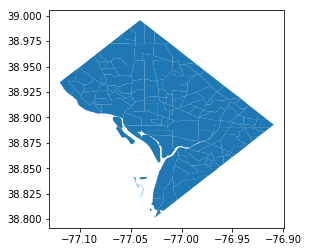

In [77]:
shape.plot()

In [78]:
# https://stackoverflow.com/questions/7861196/check-if-a-geopoint-with-latitude-and-longitude-is-within-a-shapefile?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# credit to Richard

import ogr
from IPython import embed
import sys

drv = ogr.GetDriverByName('ESRI Shapefile') #We will load a shape file
ds_in = drv.Open("data/ZillowNeighborhoods-DC.shp")    #Get the contents of the shape file
lyr_in = ds_in.GetLayer(0)    #Get the shape file's first layer

#Put the title of the field you are interested in here
idx_reg = lyr_in.GetLayerDefn().GetFieldIndex("name")

#If the latitude/longitude we're going to use is not in the projection
#of the shapefile, then we will get erroneous results.
#The following assumes that the latitude longitude is in WGS84
#This is identified by the number "4326", as in "EPSG:4326"
#We will create a transformation between this and the shapefile's
#project, whatever it may be
geo_ref = lyr_in.GetSpatialRef()
point_ref=ogr.osr.SpatialReference()
point_ref.ImportFromEPSG(4326)
ctran=ogr.osr.CoordinateTransformation(point_ref,geo_ref)

def check(lon,lat):
    #Create a point
    pt = ogr.Geometry(ogr.wkbPoint)
    pt.SetPoint_2D(0, lon, lat)

    #Set up a spatial filter such that the only features we see when we
    #loop through "lyr_in" are those which overlap the point defined above
    lyr_in.SetSpatialFilter(pt)

    #Loop through the overlapped features and display the field of interest
    for feat_in in lyr_in:
        return feat_in.GetFieldAsString(idx_reg)

In [79]:
this_is_a_neighborhoods = []
for index, row in grouped_foursquare.iterrows():
    this_is_a_neighborhoods.append(check(row.longitude, row.latitude))

In [80]:
this_is_a_neighborhoods[0:10]

['Dupont Circle',
 'Shaw',
 'Shaw',
 'Shaw',
 'Shaw',
 'Shaw',
 'Capitol Hill',
 'Downtown',
 'Navy Yard',
 'Navy Yard']

In [81]:
import csv
with open('./data/neighborhoodsToZip.csv', 'r') as f:
    reader = csv.reader(f)
    conversion = dict(reader)
del conversion['Neighborhood']

In [82]:
conversion

{'': '20001',
 'Adams Morgan': '20009',
 'American University Park': '20016',
 'Arboretum': '20002',
 'Barnaby Woods': '20015',
 'Barry Farm': '20020',
 'Bellevue': '20032',
 'Benning': '20019',
 'Benning Heights': '20019',
 'Bloomingdale': '20017',
 'Brentwood': '20722',
 'Brightwood': '20011',
 'Brightwood Park': '20011',
 'Brookland': '20017',
 'Buena Vista': '20020',
 'Burleith': '20007',
 'Burrville': '20019',
 'Buzzard Point': '20024',
 'Capitol Hill': '20003',
 'Capitol View': '20020',
 'Cardozo': '20001',
 'Carver Langston': '20002',
 'Cathedral Heights': '20016',
 'Chevy Chase': '20015',
 'Chinatown': '20001',
 'Cleveland Park': '20008',
 'Colonial Village': '20012',
 'Columbia Heights': '20010',
 'Congress Heights': '20032',
 'Connecticut Avenue': '20036',
 'Crestwood': '20011',
 'Deanwood': '20019',
 'Douglass': '20020',
 'Downtown': '20001',
 'Dupont Circle': '20036',
 'Dupont Park': '20020',
 'Eastland Gardens': '20019',
 'Eckington': '20002',
 'Edgewood': '20017',
 'Fairf

In [83]:
conversions = []
for i in this_is_a_neighborhoods:
    try:
        conversions.append(conversion[i])
    except KeyError:
        conversions.append('99999')

In [84]:
print(len(conversions))
print(grouped_foursquare.shape)

67075
(67075, 8)


In [85]:
grouped_foursquare['zip_code'] = conversions

In [86]:
grouped_foursquare.zip_code.value_counts()

20001    19509
99999    16804
20036     6731
20003     4237
20007     3827
20004     3296
20002     3058
20037     2834
20009     2131
20010     2120
20008     1144
20024      876
20017      485
20722       18
20020        3
20011        2
Name: zip_code, dtype: int64

In [87]:
grouped_foursquare = grouped_foursquare[grouped_foursquare.zip_code != '99999']

In [88]:
grouped_foursquare.zip_code.value_counts()

20001    19509
20036     6731
20003     4237
20007     3827
20004     3296
20002     3058
20037     2834
20009     2131
20010     2120
20008     1144
20024      876
20017      485
20722       18
20020        3
20011        2
Name: zip_code, dtype: int64

In [92]:
grouped_foursquare.venue_category.value_counts().head()

Coffee Shop            2378
Office                 2223
Subway                 2043
American Restaurant    1844
Bar                    1804
Name: venue_category, dtype: int64

#### Export the altered dataframe into a file for later use

In [25]:
grouped_foursquare.to_csv('./data/foursquare.csv', sep='\t')

<a id="reimport_data"></a>
## Import cleaned datasets
#### <font color=Red>Start running here to import cleaned dataframes; reading dataframes into memory and re-converting datatypes</font>

In [26]:
businesses_df = pd.read_csv('./data/businesses.csv', sep="\t", index_col=0, encoding='latin-1')
businesses_df.dtypes

name             object
latitude        float64
longitude       float64
address          object
city             object
country          object
state            object
zip_code          int64
categories       object
price            object
rating          float64
review_count      int64
dtype: object

In [27]:
businesses_df['zip_code'] = businesses_df['zip_code'].astype(str)

In [28]:
businesses_df.head()

,name,latitude,longitude,address,city,country,state,zip_code,categories,price,rating,review_count
0,Old Ebbitt Grill,38.898005,-77.033362,675 15th St NW,"Washington, DC",US,DC,20005,"['Bars', 'American (Traditional)', 'Breakfast ...",$$,4.0,6544
1,A Baked Joint,38.902411,-77.017139,440 K St NW,"Washington, DC",US,DC,20001,"['Coffee & Tea', 'Breakfast & Brunch', 'Sandwi...",$,4.5,1218
2,Le Diplomate,38.911359,-77.031575,1601 14th St NW,"Washington, DC",US,DC,20009,"['Brasseries', 'French', 'Cafes']",$$$,4.0,2449
3,Rasika,38.895008,-77.021286,633 D St NW,"Washington, DC",US,DC,20004,['Indian'],$$$,4.5,2633
4,Matchbox - Chinatown,38.900050,-77.022540,713 H St NW,"Washington, DC",US,DC,20001,"['Pizza', 'American (New)']",$$,4.0,2673


In [29]:
foursquare_df = pd.read_csv('./data/foursquare.csv', sep="\t", index_col=0)
foursquare_df['utc_time'] = pd.to_datetime(foursquare_df['utc_time'], infer_datetime_format=True)
foursquare_df['zip_code'] = foursquare_df['zip_code'].astype(str)
foursquare_df.dtypes
# foursquare_df.shape

user_id                     int64
venue_id                   object
utc_time           datetime64[ns]
latitude                  float64
longitude                 float64
venue_category             object
country                    object
coffee_shop_bin             int64
zip_code                   object
dtype: object

## Explore Data

#### Hypothesis 1: Find where people who go to coffee shops go on the same day, and then find a location with a lot of this type of estabishment.

- First, I'll need to pick which categories I'll include, and then transcribe them to individual columns. Each row will be one day for one user, and the values for each category column will be 1 if the person visited this type of category on that day, and 0 if not.

In [34]:
# first, list all of the columns
foursquare_df.venue_category.unique()

array(['Shoe Store', 'Lounge', 'Bar', 'Sandwich Place',
       'Baseball Stadium', 'Zoo', 'Greek Restaurant', 'Bank',
       'Train Station', 'Neighborhood', 'American Restaurant',
       'Coffee Shop', 'Tech Startup', 'Seafood Restaurant', 'Subway',
       'Pizza Place', 'History Museum', 'Mall', 'Hotel',
       'Government Building', 'Department Store', 'Gym / Fitness Center',
       'Indian Restaurant', 'Light Rail', 'Sports Bar', 'Caf\x1a\x1a',
       'Cocktail Bar', 'Yoga Studio', 'Clothing Store', 'Military Base',
       'Bookstore', 'Gym', 'Park', 'Plaza', 'Whisky Bar', 'Office',
       'Community College', 'Museum', 'Mediterranean Restaurant', 'Pub',
       'Breakfast Spot', 'High School', 'Nightlife Spot', 'Grocery Store',
       'Steakhouse', "Men's Store", 'Music Venue', 'Hotel Bar', 'Theater',
       'Dive Bar', 'Italian Restaurant', 'Fast Food Restaurant',
       'Liquor Store', 'Turkish Restaurant', 'Ice Cream Shop',
       'Drugstore / Pharmacy', 'Cafeteria', 'Arts & Cra

In [192]:
# for now, I'll just use the top 23 categories as my features
columns=foursquare_df.venue_category.value_counts().head(23).index.tolist()

In [193]:
foursquare_days_df = foursquare_df.rename(columns={'utc_time':'utc_time_full'}).groupby([foursquare_df.user_id, foursquare_df.utc_time.dt.day]).nth(0).reset_index(drop=True)

In [194]:
foursquare_days_df.head()

,user_id,venue_id,utc_time_full,latitude,longitude,venue_category,country,coffee_shop_bin,zip_code
0,6,4c9248ed2626a1cd534a396b,2013-04-03 16:49:50,38.882935,-77.007446,Government Building,US,0,20003
1,6,4c9248ed2626a1cd534a396b,2012-10-18 16:01:06,38.882935,-77.007446,Government Building,US,1,20003
2,6,4bba0ad6cf2fc9b6260ca102,2013-05-22 20:16:02,38.900866,-77.028090,Steakhouse,US,1,20001
3,6,4aa06751f964a520813f20e3,2013-02-27 18:10:19,38.901389,-77.037743,Bar,US,0,20001
4,6,45d3780ff964a520be421fe3,2012-11-28 15:04:14,38.889747,-77.006071,Capitol Building,US,0,20003


In [195]:
foursquare_days_df.drop(['venue_id', 'latitude', 'longitude', 'venue_category', 'country', 'coffee_shop_bin', 'zip_code'], axis=1, inplace=True)

In [200]:
foursquare_days_df.head()

,user_id,utc_time_full,Coffee Shop,Office,Subway,American Restaurant,Bar,Government Building,Hotel,Train Station,...,Mexican Restaurant,Sandwich Place,Lounge,Building,Pizza Place,Pub,Neighborhood,Baseball Stadium,Road,Italian Restaurant
0,6,2013-04-03 16:49:50,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,2012-10-18 16:01:06,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,2013-05-22 20:16:02,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,2013-02-27 18:10:19,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,6,2012-11-28 15:04:14,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
foursquare_days_df.drop(foursquare_days_df.index[100:], inplace=True)

In [198]:
foursquare_df_temp = foursquare_df

In [199]:
import timeit
start_time = timeit.default_timer()

for column in columns:
    foursquare_days_df[column] = foursquare_days_df.apply(lambda row: 1 if foursquare_df_temp[(foursquare_df_temp['user_id'] == row['user_id']) & (foursquare_df_temp.utc_time.dt.day == row['utc_time_full'].day) & (foursquare_df_temp.venue_category == column)].venue_category.count() > 0 else 0, axis=1)
    foursquare_df_temp = foursquare_df_temp[foursquare_df_temp['venue_category'] != column]
    
timeit.default_timer() - start_time

16.267356007120725

In [ ]:
foursquare_days_df.head()

In [11]:
foursquare_df.head()

,user_id,venue_id,utc_time,latitude,longitude,venue_category,country,coffee_shop_bin,zip_code
373,22,4acbb808f964a52021c520e3,2012-05-01 22:50:42,38.916963,-77.036772,Shoe Store,US,1,20036
447,14591,4a2d9fc5f964a520d7971fe3,2012-04-03 18:04:12,38.915772,-77.032071,Lounge,US,1,20001
448,14591,4a2d9fc5f964a520d7971fe3,2012-04-13 23:37:41,38.915772,-77.032071,Lounge,US,1,20001
449,14591,4a2d9fc5f964a520d7971fe3,2012-05-15 17:43:10,38.915772,-77.032071,Lounge,US,1,20001
450,47240,4a2d9fc5f964a520d7971fe3,2012-07-11 22:40:04,38.915772,-77.032071,Lounge,US,1,20001


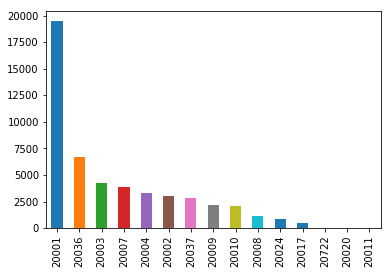

In [12]:
foursquare_df.zip_code.value_counts().plot(kind='bar')

<a id="explore_data_old"></a>
## Explore Data (Old Hypotheses)

#### See where people are generally coming from when they go to coffee shops

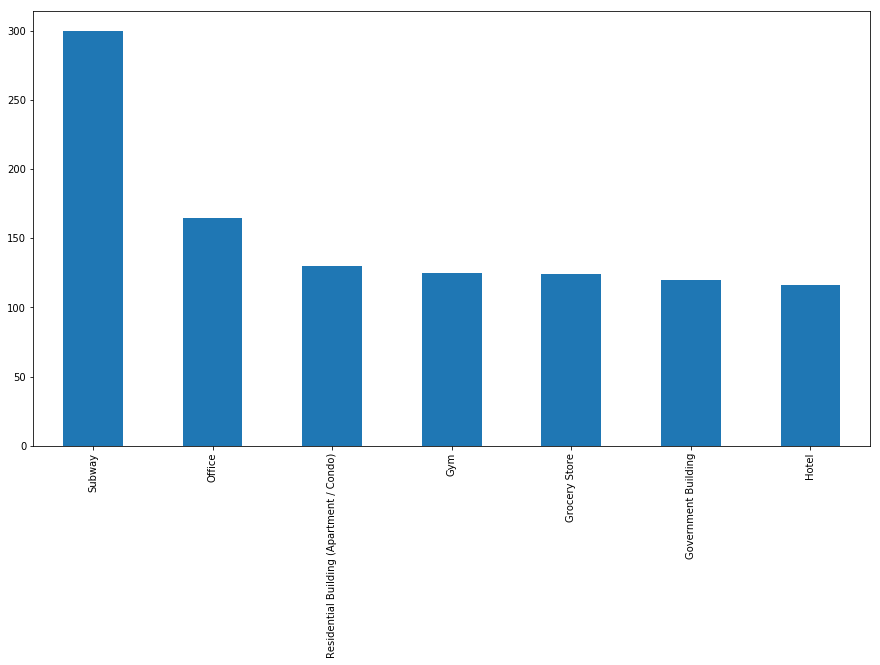

In [15]:
# View top 10 categories of checkins on days that also contain a coffee shop checkin
foursquare_df[(foursquare_df.coffee_shop_bin==1) & (foursquare_df.venue_category != 'Coffee Shop')].venue_category.value_counts().head(7).plot(kind='bar', figsize=(15, 8))

#### I too go to starbucks after every subway sub.

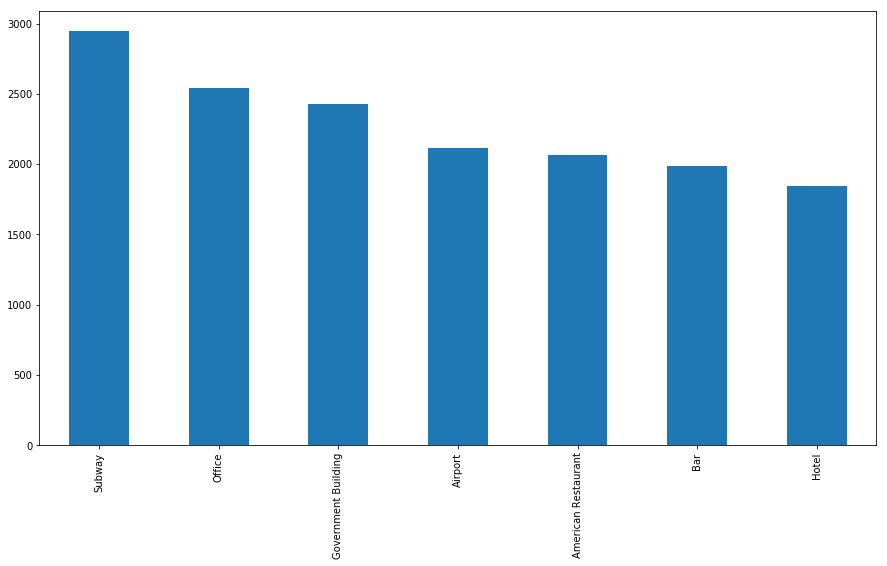

In [32]:
foursquare_df.venue_category.value_counts().head(7).plot(kind='bar', figsize=(15, 8))

#### Next I'd like to view coffee shops plotted on an interactive map.

In [24]:
import folium

In [25]:
map_coffee_df = businesses_df[businesses_df.categories.astype(str).str.contains('Coffee')]

folium_map = folium.Map(location=[38.9031434, -77.0232301],
                        zoom_start=13)

for index, row in map_coffee_df.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=folium.Popup(row['name'], parse_html=True)).add_to(folium_map)

In [26]:
folium_map

#### Next I want to find a count of coffee shops by zip code and explore population data viability on determining coffee shop location

In [27]:
# get all businesses w/ category containing "Coffee"
coffeeshops_byzip_df = businesses_df[businesses_df.categories.astype(str).str.contains('Coffee')]
coffeeshops_byzip_df.shape

(390, 12)

In [28]:
# new df containing each zip code and the count of coffee shops
coffeeshop_percap_df = coffeeshops_byzip_df.groupby('zip_code').zip_code.agg(['count']).sort_values('count', ascending=False)

# merge previous dataframe with population growth dataframe
coffeeshop_percap_df = coffeeshop_percap_df.merge(populchange_df, left_index=True, right_on="zip_code")
coffeeshop_percap_df = coffeeshop_percap_df.set_index('zip_code')

# add calculated field for rate of population change
coffeeshop_percap_df['pop_change_rate'] = (coffeeshop_percap_df['estimate_total_2016'] - \
                                            coffeeshop_percap_df['estimate_total_2015']) / \
                                            coffeeshop_percap_df['estimate_total_2015']

# display some rows from newly constructed df, sorted by population rate of change
coffeeshop_percap_df[coffeeshop_percap_df['count'] > 5].sort_values('pop_change_rate')

,count,estimate_total_2015,estimate_total_2016,pop_change_rate
zip_code,,,,
20037,18,15687,15285,-0.025626
20007,20,26687,26415,-0.010192
20010,8,32544,32421,-0.003779
20009,41,51499,51508,0.000175
20016,15,35101,35192,0.002593
20008,8,28141,28261,0.004264
20006,31,2905,2920,0.005164
20005,33,12947,13063,0.008960
20011,14,66571,67349,0.011687
